# Stratified Sampling

In [1]:
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import matplotlib.pyplot as plt

# Set max columns and rows for displaying large dataframes
pd.set_option('display.max_columns', 999)
pd.set_option('display.max_rows', 999)
plt.rcParams["figure.figsize"] = (16, 9)

## Preparing the data
The primary dataset for training and validating loan default predictions has been obtained from [Kaggle](https://www.kaggle.com/wendykan/lending-club-loan-data).

In [2]:
data = pd.read_csv('loan.csv', low_memory=False)

In [3]:
data.head(3)

,id,member_id,loan_amnt,funded_amnt,funded_amnt_inv,term,int_rate,installment,grade,sub_grade,emp_title,emp_length,home_ownership,annual_inc,verification_status,issue_d,loan_status,pymnt_plan,url,desc,purpose,title,zip_code,addr_state,dti,delinq_2yrs,earliest_cr_line,inq_last_6mths,mths_since_last_delinq,mths_since_last_record,open_acc,pub_rec,revol_bal,revol_util,total_acc,initial_list_status,out_prncp,out_prncp_inv,total_pymnt,total_pymnt_inv,total_rec_prncp,total_rec_int,total_rec_late_fee,recoveries,collection_recovery_fee,last_pymnt_d,last_pymnt_amnt,next_pymnt_d,last_credit_pull_d,collections_12_mths_ex_med,mths_since_last_major_derog,policy_code,application_type,annual_inc_joint,dti_joint,verification_status_joint,acc_now_delinq,tot_coll_amt,tot_cur_bal,open_acc_6m,open_act_il,open_il_12m,open_il_24m,mths_since_rcnt_il,total_bal_il,il_util,open_rv_12m,open_rv_24m,max_bal_bc,all_util,total_rev_hi_lim,inq_fi,total_cu_tl,inq_last_12m,acc_open_past_24mths,avg_cur_bal,bc_open_to_buy,bc_util,chargeoff_within_12_mths,delinq_amnt,mo_sin_old_il_acct,mo_sin_old_rev_tl_op,mo_sin_rcnt_rev_tl_op,mo_sin_rcnt_tl,mort_acc,mths_since_recent_bc,mths_since_recent_bc_dlq,mths_since_recent_inq,mths_since_recent_revol_delinq,num_accts_ever_120_pd,num_actv_bc_tl,num_actv_rev_tl,num_bc_sats,num_bc_tl,num_il_tl,num_op_rev_tl,num_rev_accts,num_rev_tl_bal_gt_0,num_sats,num_tl_120dpd_2m,num_tl_30dpd,num_tl_90g_dpd_24m,num_tl_op_past_12m,pct_tl_nvr_dlq,percent_bc_gt_75,pub_rec_bankruptcies,tax_liens,tot_hi_cred_lim,total_bal_ex_mort,total_bc_limit,total_il_high_credit_limit,revol_bal_joint,sec_app_earliest_cr_line,sec_app_inq_last_6mths,sec_app_mort_acc,sec_app_open_acc,sec_app_revol_util,sec_app_open_act_il,sec_app_num_rev_accts,sec_app_chargeoff_within_12_mths,sec_app_collections_12_mths_ex_med,sec_app_mths_since_last_major_derog,hardship_flag,hardship_type,hardship_reason,hardship_status,deferral_term,hardship_amount,hardship_start_date,hardship_end_date,payment_plan_start_date,hardship_length,hardship_dpd,hardship_loan_status,orig_projected_additional_accrued_interest,hardship_payoff_balance_amount,hardship_last_payment_amount,disbursement_method,debt_settlement_flag,debt_settlement_flag_date,settlement_status,settlement_date,settlement_amount,settlement_percentage,settlement_term
0,NaN,NaN,2500,2500,2500.0,36 months,13.56,84.92,C,C1,Chef,10+ years,RENT,55000.0,Not Verified,Dec-2018,Current,n,NaN,NaN,debt_consolidation,Debt consolidation,109xx,NY,18.24,0.0,Apr-2001,1.0,NaN,45.0,9.0,1.0,4341,10.3,34.0,w,2386.02,2386.02,167.02,167.02,113.98,53.04,0.0,0.0,0.0,Feb-2019,84.92,Mar-2019,Feb-2019,0.0,NaN,1,Individual,NaN,NaN,NaN,0.0,0.0,16901.0,2.0,2.0,1.0,2.0,2.0,12560.0,69.0,2.0,7.0,2137.0,28.0,42000.0,1.0,11.0,2.0,9.0,1878.0,34360.0,5.9,0.0,0.0,140.0,212.0,1.0,1.0,0.0,1.0,NaN,2.0,NaN,0.0,2.0,5.0,3.0,3.0,16.0,7.0,18.0,5.0,9.0,0.0,0.0,0.0,3.0,100.0,0.0,1.0,0.0,60124.0,16901.0,36500.0,18124.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,N,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,Cash,N,NaN,NaN,NaN,NaN,NaN,NaN
1,NaN,NaN,30000,30000,30000.0,60 months,18.94,777.23,D,D2,Postmaster,10+ years,MORTGAGE,90000.0,Source Verified,Dec-2018,Current,n,NaN,NaN,debt_consolidation,Debt consolidation,713xx,LA,26.52,0.0,Jun-1987,0.0,71.0,75.0,13.0,1.0,12315,24.2,44.0,w,29387.75,29387.75,1507.11,1507.11,612.25,894.86,0.0,0.0,0.0,Feb-2019,777.23,Mar-2019,Feb-2019,0.0,NaN,1,Individual,NaN,NaN,NaN,0.0,1208.0,321915.0,4.0,4.0,2.0,3.0,3.0,87153.0,88.0,4.0,5.0,998.0,57.0,50800.0,2.0,15.0,2.0,10.0,24763.0,13761.0,8.3,0.0,0.0,163.0,378.0,4.0,3.0,3.0,4.0,NaN,4.0,NaN,0.0,2.0,4.0,4.0,9.0,27.0,8.0,14.0,4.0,13.0,0.0,0.0,0.0,6.0,95.0,0.0,1.0,0.0,372872.0,99468.0,15000.0,94072.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,N,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,Cash,N,NaN,NaN,NaN,NaN,NaN,NaN
2,NaN,NaN,5000,5000,5000.0,36 months,17.97,180.69,D,D1,Administrative,6 years,MORTGAGE,59280.0,Source Verified,Dec-2018,Current,n,NaN,NaN,debt_consolidation,Debt cons

In [4]:
data.shape

(2260668, 145)

### Target

Let us first explore the target column - loan_status.

In [5]:
target='loan_status'

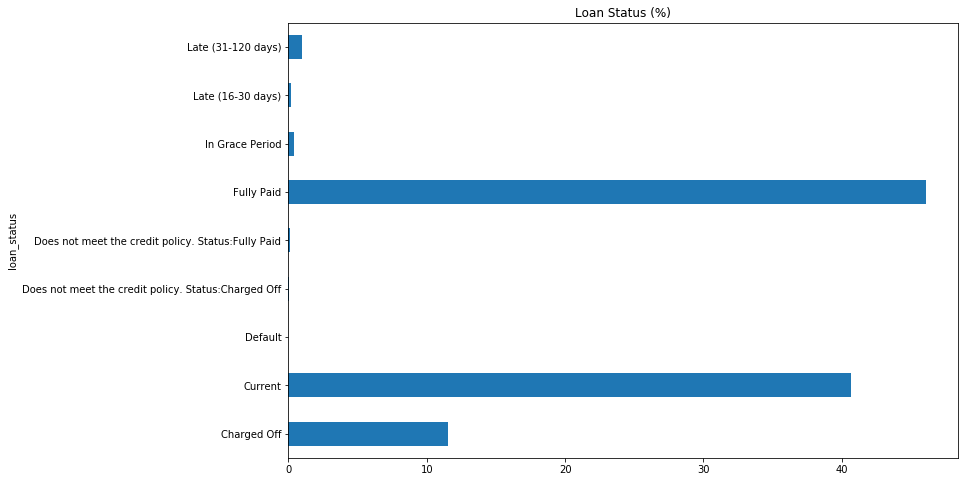

In [6]:
plt.rcParams["figure.figsize"] = (12, 8)
df = 100 * data.groupby(['loan_status'])['loan_amnt'].count() / data['loan_amnt'].count()
df.plot.barh(title='Loan Status (%)', rot=0)
plt.show()

Now, let's transform the different loan_status categories to either 'good' or 'bad'.

In [7]:
status = {
    'Charged Off': 'bad',
    'Current': 'good',
    'Default': 'bad',
    'Does not meet the credit policy. Status:Charged Off': 'bad',
    'Does not meet the credit policy. Status:Fully Paid': 'good',
    'Fully Paid': 'good',
    'In Grace Period': 'bad',
    'Late (16-30 days)': 'bad',
    'Late (31-120 days)': 'bad'
}
data['loan_status'] = data['loan_status'].map(lambda x: status[x])

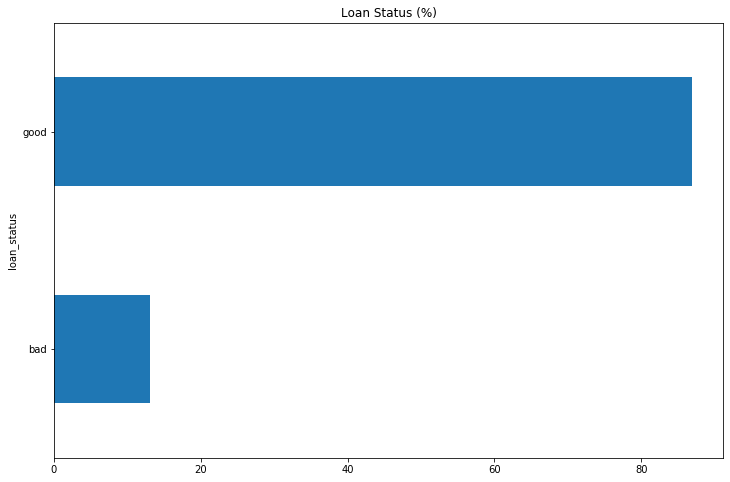

In [8]:
df = 100 * data.groupby(['loan_status'])['loan_amnt'].count() / data['loan_amnt'].count()
df.plot.barh(title='Loan Status (%)', rot=0)
plt.show()

### Feature Transformation

The 'term' feature has the string 'months' appended to its numerical values. This needs to be removed. 

In [9]:
data['term'] = data['term'].dropna().map(lambda term: int(term.replace("months", "").strip()))
data['term'] = data['term'].dropna().astype('str')

Some features have dates. So, let's retain only the year from the dates. 

In [10]:
columns=['issue_d', 'earliest_cr_line']
for col in np.intersect1d(columns, data.columns):
    data[col] = data[col].dropna().map(lambda date: int(date.split('-')[1].strip()))
    data[col] = data[col].dropna().astype('str')

### Finally

In [11]:
data.head(3)

,id,member_id,loan_amnt,funded_amnt,funded_amnt_inv,term,int_rate,installment,grade,sub_grade,emp_title,emp_length,home_ownership,annual_inc,verification_status,issue_d,loan_status,pymnt_plan,url,desc,purpose,title,zip_code,addr_state,dti,delinq_2yrs,earliest_cr_line,inq_last_6mths,mths_since_last_delinq,mths_since_last_record,open_acc,pub_rec,revol_bal,revol_util,total_acc,initial_list_status,out_prncp,out_prncp_inv,total_pymnt,total_pymnt_inv,total_rec_prncp,total_rec_int,total_rec_late_fee,recoveries,collection_recovery_fee,last_pymnt_d,last_pymnt_amnt,next_pymnt_d,last_credit_pull_d,collections_12_mths_ex_med,mths_since_last_major_derog,policy_code,application_type,annual_inc_joint,dti_joint,verification_status_joint,acc_now_delinq,tot_coll_amt,tot_cur_bal,open_acc_6m,open_act_il,open_il_12m,open_il_24m,mths_since_rcnt_il,total_bal_il,il_util,open_rv_12m,open_rv_24m,max_bal_bc,all_util,total_rev_hi_lim,inq_fi,total_cu_tl,inq_last_12m,acc_open_past_24mths,avg_cur_bal,bc_open_to_buy,bc_util,chargeoff_within_12_mths,delinq_amnt,mo_sin_old_il_acct,mo_sin_old_rev_tl_op,mo_sin_rcnt_rev_tl_op,mo_sin_rcnt_tl,mort_acc,mths_since_recent_bc,mths_since_recent_bc_dlq,mths_since_recent_inq,mths_since_recent_revol_delinq,num_accts_ever_120_pd,num_actv_bc_tl,num_actv_rev_tl,num_bc_sats,num_bc_tl,num_il_tl,num_op_rev_tl,num_rev_accts,num_rev_tl_bal_gt_0,num_sats,num_tl_120dpd_2m,num_tl_30dpd,num_tl_90g_dpd_24m,num_tl_op_past_12m,pct_tl_nvr_dlq,percent_bc_gt_75,pub_rec_bankruptcies,tax_liens,tot_hi_cred_lim,total_bal_ex_mort,total_bc_limit,total_il_high_credit_limit,revol_bal_joint,sec_app_earliest_cr_line,sec_app_inq_last_6mths,sec_app_mort_acc,sec_app_open_acc,sec_app_revol_util,sec_app_open_act_il,sec_app_num_rev_accts,sec_app_chargeoff_within_12_mths,sec_app_collections_12_mths_ex_med,sec_app_mths_since_last_major_derog,hardship_flag,hardship_type,hardship_reason,hardship_status,deferral_term,hardship_amount,hardship_start_date,hardship_end_date,payment_plan_start_date,hardship_length,hardship_dpd,hardship_loan_status,orig_projected_additional_accrued_interest,hardship_payoff_balance_amount,hardship_last_payment_amount,disbursement_method,debt_settlement_flag,debt_settlement_flag_date,settlement_status,settlement_date,settlement_amount,settlement_percentage,settlement_term
0,NaN,NaN,2500,2500,2500.0,36,13.56,84.92,C,C1,Chef,10+ years,RENT,55000.0,Not Verified,2018,good,n,NaN,NaN,debt_consolidation,Debt consolidation,109xx,NY,18.24,0.0,2001.0,1.0,NaN,45.0,9.0,1.0,4341,10.3,34.0,w,2386.02,2386.02,167.02,167.02,113.98,53.04,0.0,0.0,0.0,Feb-2019,84.92,Mar-2019,Feb-2019,0.0,NaN,1,Individual,NaN,NaN,NaN,0.0,0.0,16901.0,2.0,2.0,1.0,2.0,2.0,12560.0,69.0,2.0,7.0,2137.0,28.0,42000.0,1.0,11.0,2.0,9.0,1878.0,34360.0,5.9,0.0,0.0,140.0,212.0,1.0,1.0,0.0,1.0,NaN,2.0,NaN,0.0,2.0,5.0,3.0,3.0,16.0,7.0,18.0,5.0,9.0,0.0,0.0,0.0,3.0,100.0,0.0,1.0,0.0,60124.0,16901.0,36500.0,18124.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,N,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,Cash,N,NaN,NaN,NaN,NaN,NaN,NaN
1,NaN,NaN,30000,30000,30000.0,60,18.94,777.23,D,D2,Postmaster,10+ years,MORTGAGE,90000.0,Source Verified,2018,good,n,NaN,NaN,debt_consolidation,Debt consolidation,713xx,LA,26.52,0.0,1987.0,0.0,71.0,75.0,13.0,1.0,12315,24.2,44.0,w,29387.75,29387.75,1507.11,1507.11,612.25,894.86,0.0,0.0,0.0,Feb-2019,777.23,Mar-2019,Feb-2019,0.0,NaN,1,Individual,NaN,NaN,NaN,0.0,1208.0,321915.0,4.0,4.0,2.0,3.0,3.0,87153.0,88.0,4.0,5.0,998.0,57.0,50800.0,2.0,15.0,2.0,10.0,24763.0,13761.0,8.3,0.0,0.0,163.0,378.0,4.0,3.0,3.0,4.0,NaN,4.0,NaN,0.0,2.0,4.0,4.0,9.0,27.0,8.0,14.0,4.0,13.0,0.0,0.0,0.0,6.0,95.0,0.0,1.0,0.0,372872.0,99468.0,15000.0,94072.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,N,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,Cash,N,NaN,NaN,NaN,NaN,NaN,NaN
2,NaN,NaN,5000,5000,5000.0,36,17.97,180.69,D,D1,Administrative,6 years,MORTGAGE,59280.0,Source Verified,2018,good,n,NaN,NaN,debt_consolidation,Debt consolidation,490xx,MI,10.51,0.0,2011.0,0.0,NaN,Na

In [12]:
data.shape

(2260668, 145)

## Visualizing the data

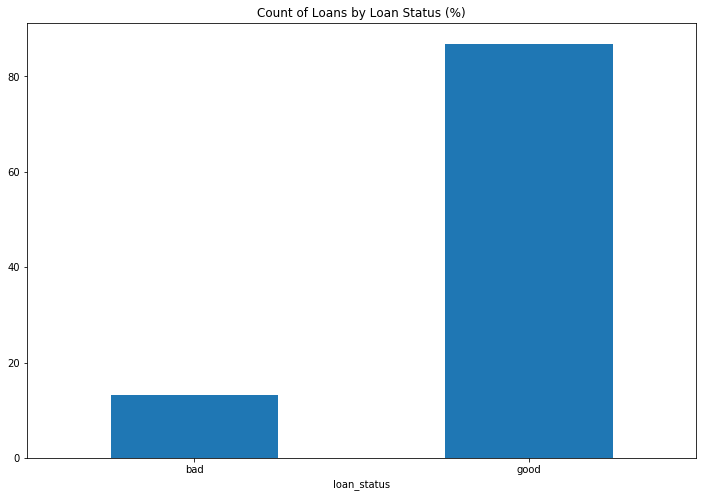

In [13]:
df = 100 * data.groupby(['loan_status'])['loan_amnt'].count() / data['loan_amnt'].count()
df.plot.bar(title='Count of Loans by Loan Status (%)', rot=0)
plt.show()

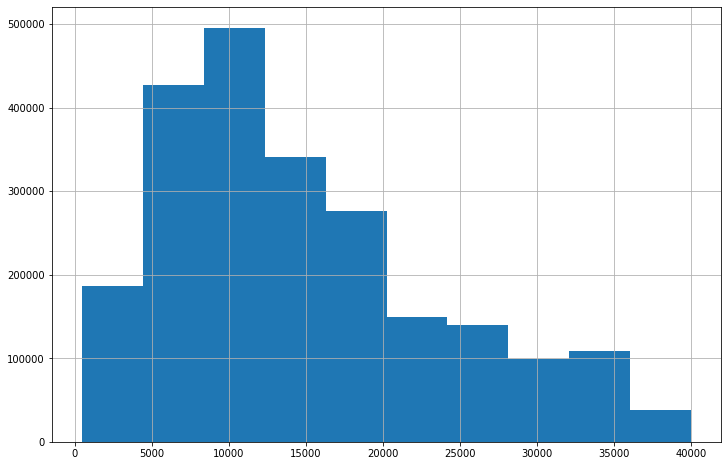

In [14]:
data['loan_amnt'].hist()

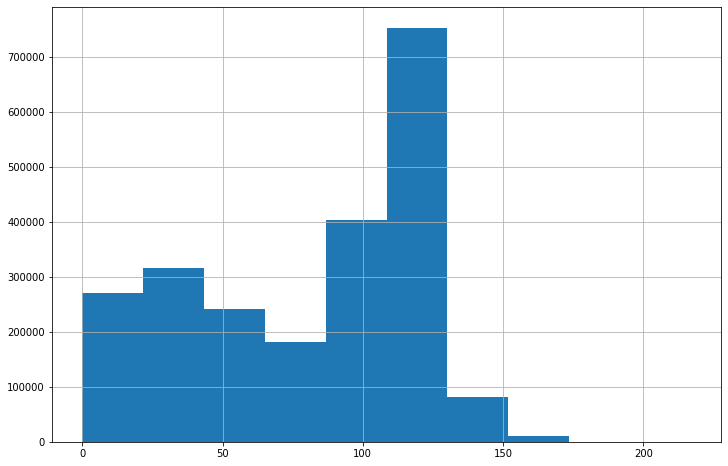

In [15]:
(100*data['total_pymnt']/data['loan_amnt']).hist()

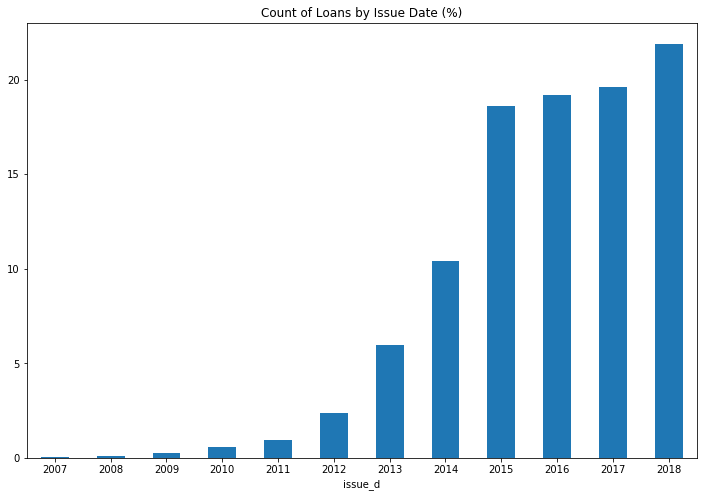

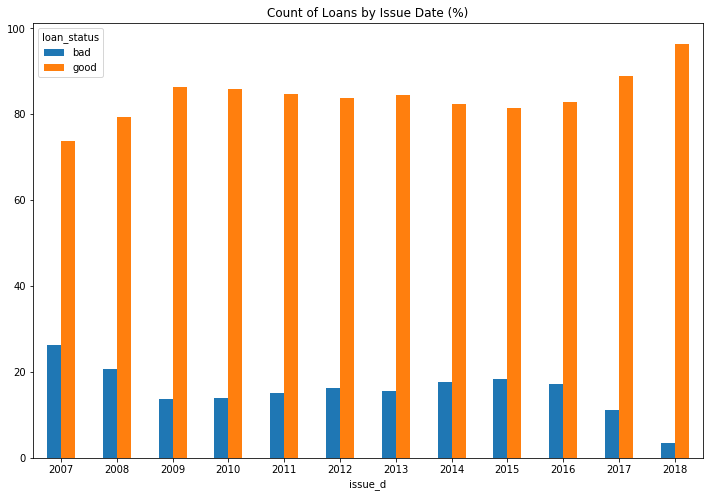

In [16]:
df = 100 * data.groupby(['issue_d'])['loan_amnt'].count() / data['loan_amnt'].count()
df.plot.bar(title='Count of Loans by Issue Date (%)', rot=0)
plt.show()

df = 100 * data.groupby(['loan_status', 'issue_d'])['loan_amnt'].count() / data.groupby(['issue_d'])['loan_amnt'].count()
df.unstack(level=0).plot.bar(title='Count of Loans by Issue Date (%)', rot=0)
plt.show()

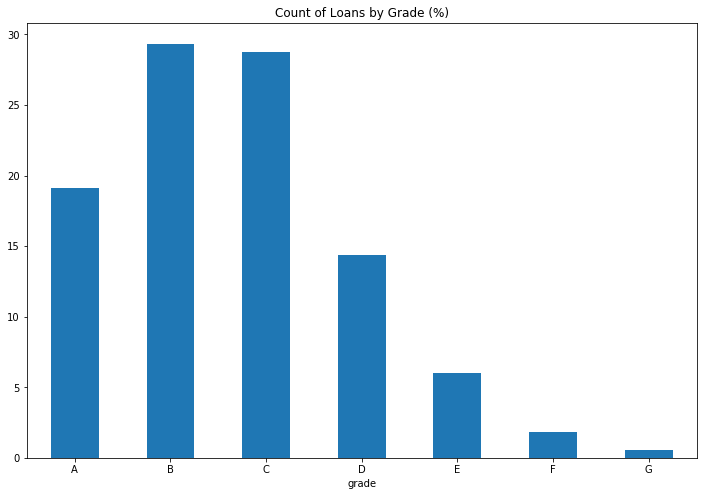

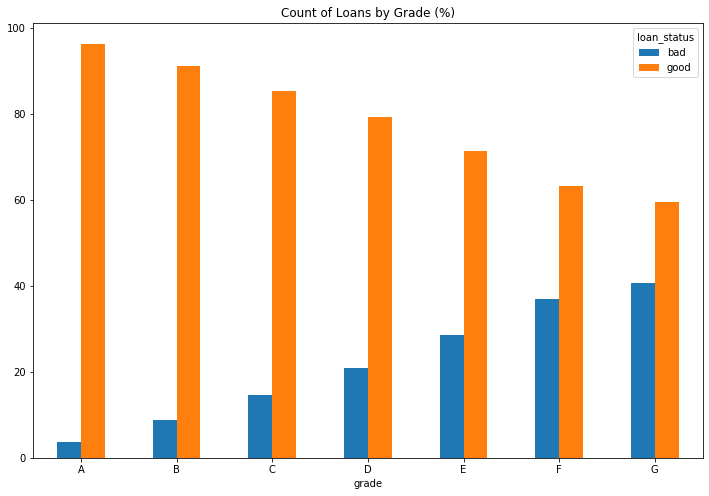

In [17]:
df = 100 * data.groupby(['grade'])['loan_amnt'].count() / data['loan_amnt'].count()
df.plot.bar(title='Count of Loans by Grade (%)', rot=0)
plt.show()

df = 100 * data.groupby(['loan_status', 'grade'])['loan_amnt'].count() / data.groupby(['grade'])['loan_amnt'].count()
df.unstack(level=0).plot.bar(title='Count of Loans by Grade (%)', rot=0)
plt.show()

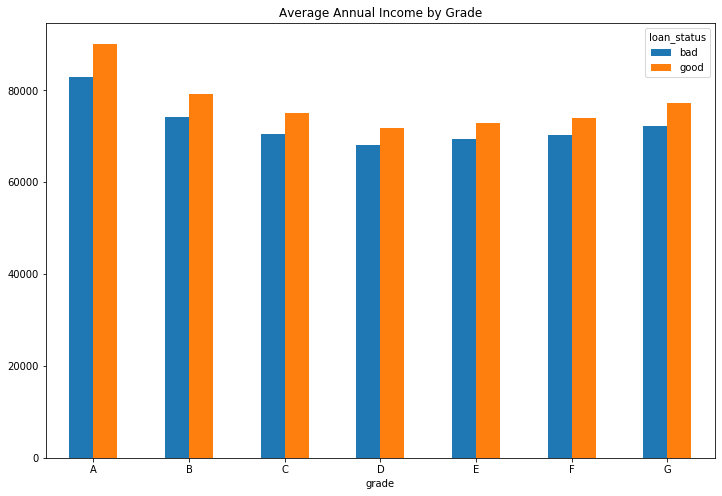

In [18]:
df = data.groupby(['loan_status', 'grade'])['annual_inc'].mean()
df.unstack(level=0).plot.bar(title='Average Annual Income by Grade', rot=0)
plt.show()

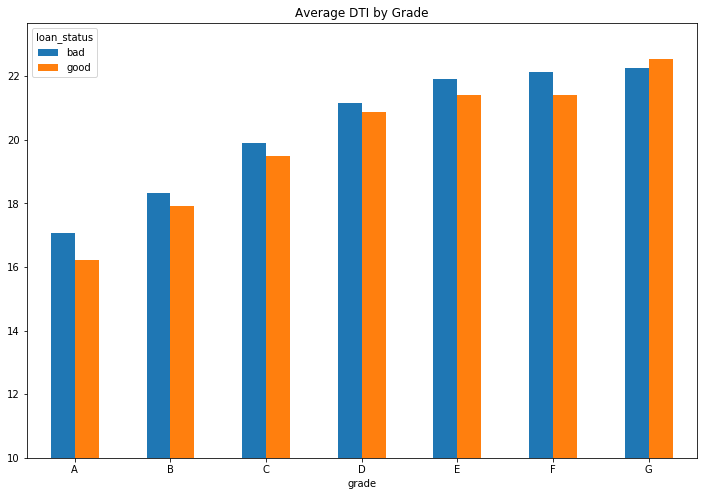

In [19]:
df = data.groupby(['loan_status', 'grade'])['dti'].mean()
df.unstack(level=0).plot.bar(title='Average DTI by Grade', rot=0, ylim=10)
plt.show()

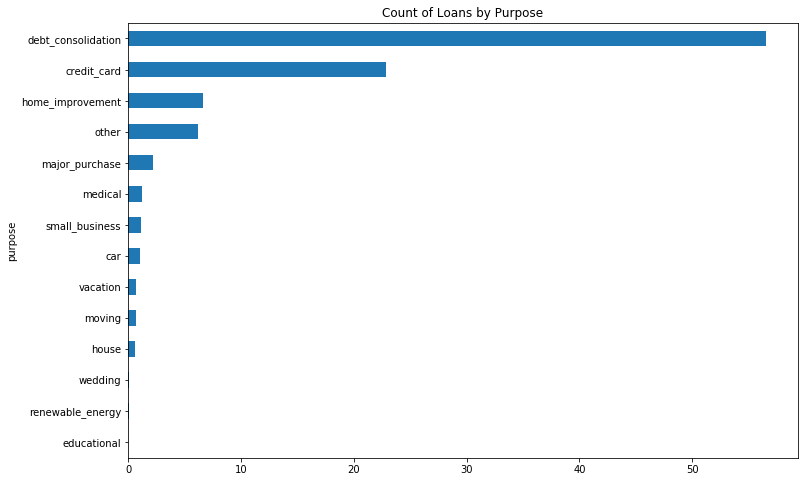

In [20]:
df = 100 * data.groupby(['purpose'])['loan_amnt'].count() / data['loan_amnt'].count()
df.sort_values().plot.barh(title='Count of Loans by Purpose', rot=0)
plt.show()

## Preprocessing the data

### Handling missing values

Some columns have critical data which cannot be assumed or inferred. If rows are found to have missing values in such columns, they need to be ignored.

In [21]:
critical_columns = ['loan_status', 'loan_amnt', 'grade', 'dti', 'annual_inc', 'term', 'purpose', 'total_pymnt', 'issue_d']
#critical_columns = ['loan_status', 'issue_d', 'purpose']
data.dropna(subset=np.intersect1d(critical_columns, data.columns), inplace=True)

Some features have too many missing values and cannot be imputed efficiently. So, let's drop them. 

In [22]:
data.dropna(axis='columns', thresh=data.shape[0]*0.95, inplace=True)

Missing values will be imputed. 

### Finally

In [23]:
data.head(3)

,loan_amnt,funded_amnt,funded_amnt_inv,term,int_rate,installment,grade,sub_grade,home_ownership,annual_inc,verification_status,issue_d,loan_status,pymnt_plan,purpose,title,zip_code,addr_state,dti,delinq_2yrs,earliest_cr_line,inq_last_6mths,open_acc,pub_rec,revol_bal,revol_util,total_acc,initial_list_status,out_prncp,out_prncp_inv,total_pymnt,total_pymnt_inv,total_rec_prncp,total_rec_int,total_rec_late_fee,recoveries,collection_recovery_fee,last_pymnt_d,last_pymnt_amnt,last_credit_pull_d,collections_12_mths_ex_med,policy_code,application_type,acc_now_delinq,tot_coll_amt,tot_cur_bal,total_rev_hi_lim,acc_open_past_24mths,avg_cur_bal,bc_open_to_buy,bc_util,chargeoff_within_12_mths,delinq_amnt,mo_sin_old_rev_tl_op,mo_sin_rcnt_rev_tl_op,mo_sin_rcnt_tl,mort_acc,mths_since_recent_bc,num_accts_ever_120_pd,num_actv_bc_tl,num_actv_rev_tl,num_bc_sats,num_bc_tl,num_il_tl,num_op_rev_tl,num_rev_accts,num_rev_tl_bal_gt_0,num_sats,num_tl_30dpd,num_tl_90g_dpd_24m,num_tl_op_past_12m,pct_tl_nvr_dlq,percent_bc_gt_75,pub_rec_bankruptcies,tax_liens,tot_hi_cred_lim,total_bal_ex_mort,total_bc_limit,total_il_high_credit_limit,hardship_flag,disbursement_method,debt_settlement_flag
0,2500,2500,2500.0,36,13.56,84.92,C,C1,RENT,55000.0,Not Verified,2018,good,n,debt_consolidation,Debt consolidation,109xx,NY,18.24,0.0,2001.0,1.0,9.0,1.0,4341,10.3,34.0,w,2386.02,2386.02,167.02,167.02,113.98,53.04,0.0,0.0,0.0,Feb-2019,84.92,Feb-2019,0.0,1,Individual,0.0,0.0,16901.0,42000.0,9.0,1878.0,34360.0,5.9,0.0,0.0,212.0,1.0,1.0,0.0,1.0,0.0,2.0,5.0,3.0,3.0,16.0,7.0,18.0,5.0,9.0,0.0,0.0,3.0,100.0,0.0,1.0,0.0,60124.0,16901.0,36500.0,18124.0,N,Cash,N
1,30000,30000,30000.0,60,18.94,777.23,D,D2,MORTGAGE,90000.0,Source Verified,2018,good,n,debt_consolidation,Debt consolidation,713xx,LA,26.52,0.0,1987.0,0.0,13.0,1.0,12315,24.2,44.0,w,29387.75,29387.75,1507.11,1507.11,612.25,894.86,0.0,0.0,0.0,Feb-2019,777.23,Feb-2019,0.0,1,Individual,0.0,1208.0,321915.0,50800.0,10.0,24763.0,13761.0,8.3,0.0,0.0,378.0,4.0,3.0,3.0,4.0,0.0,2.0,4.0,4.0,9.0,27.0,8.0,14.0,4.0,13.0,0.0,0.0,6.0,95.0,0.0,1.0,0.0,372872.0,99468.0,15000.0,94072.0,N,Cash,N
2,5000,5000,5000.0,36,17.97,180.69,D,D1,MORTGAGE,59280.0,Source Verified,2018,good,n,debt_consolidation,Debt consolidation,490xx,MI,10.51,0.0,2011.0,0.0,8.0,0.0,4599,19.1,13.0,w,4787.21,4787.21,353.89,353.89,212.79,141.10,0.0,0.0,0.0,Feb-2019,180.69,Feb-2019,0.0,1,Individual,0.0,0.0,110299.0,24100.0,4.0,18383.0,13800.0,0.0,0.0,0.0,92.0,15.0,14.0,2.0,77.0,0.0,0.0,3.0,3.0,3.0,4.0,6.0,7.0,3.0,8.0,0.0,0.0,0.0,100.0,0.0,0.0,0.0,136927.0,11749.0,13800.0,10000.0,N,Cash,N


In [24]:
data.shape

(2258953, 82)

## Stratified Sampling

In [25]:
from sklearn.model_selection import train_test_split

target = 'loan_status'
X = data.drop(target, axis='columns', inplace=False)
y = data[target]

X_unselected, X_selected, y_unselected, y_selected = train_test_split(X, y, stratify=y, random_state=123, test_size=10000)

## Visualizing the data

In [26]:
columns = ['loan_status', 'loan_amnt', 'grade', 'dti', 'annual_inc', 'term', 'purpose', 'total_pymnt', 'issue_d', 'home_ownership']

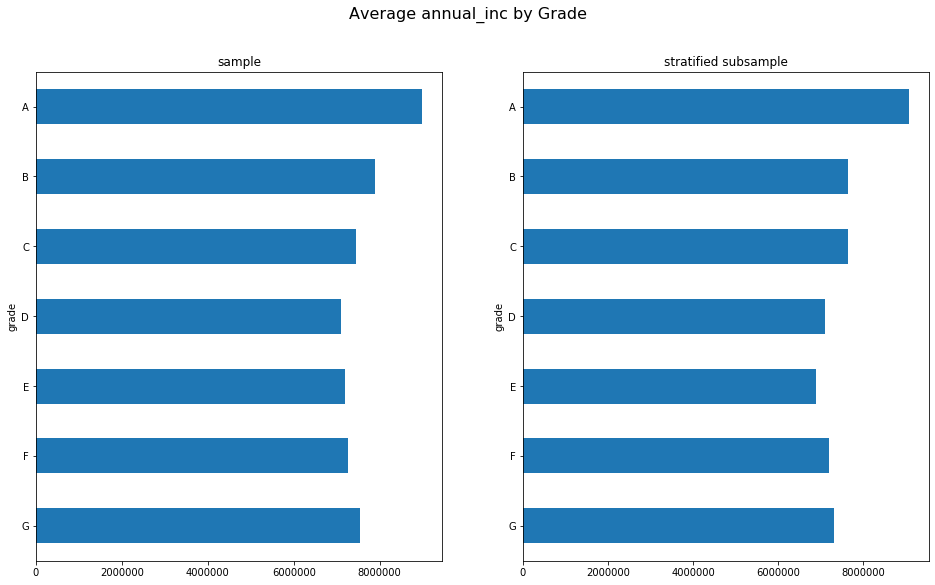

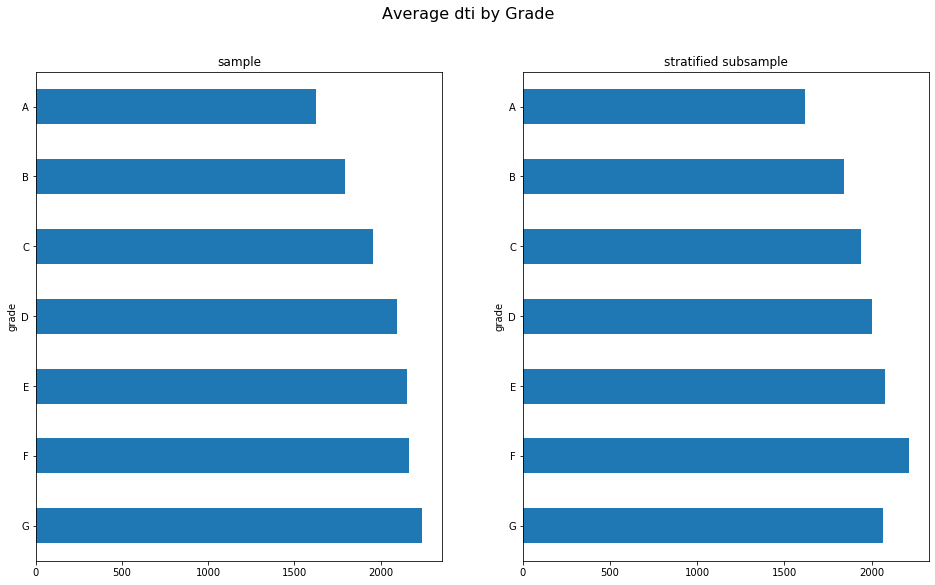

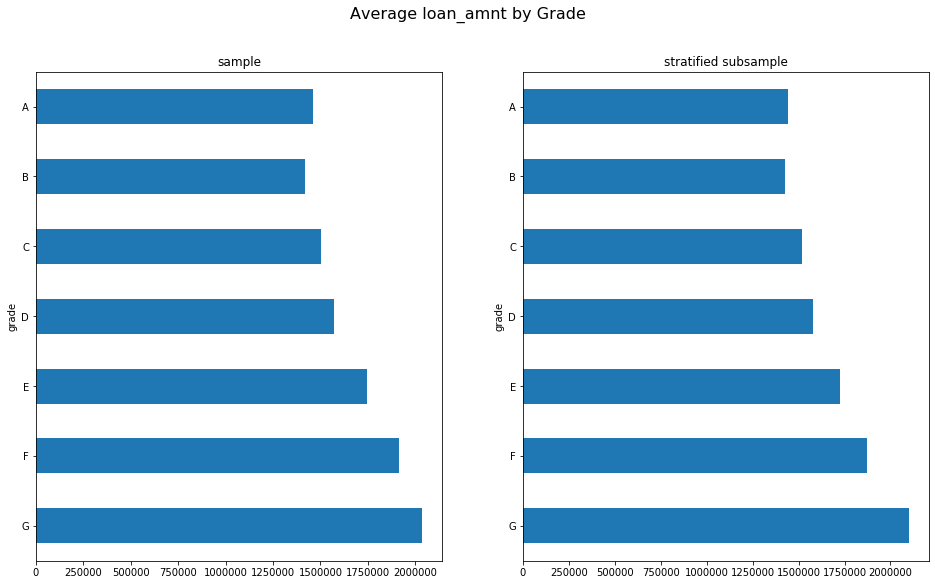

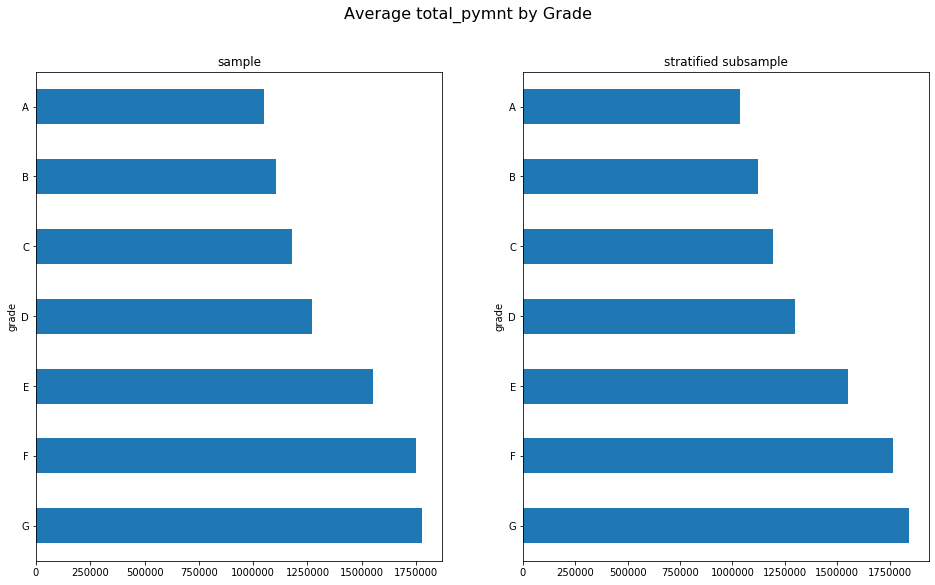

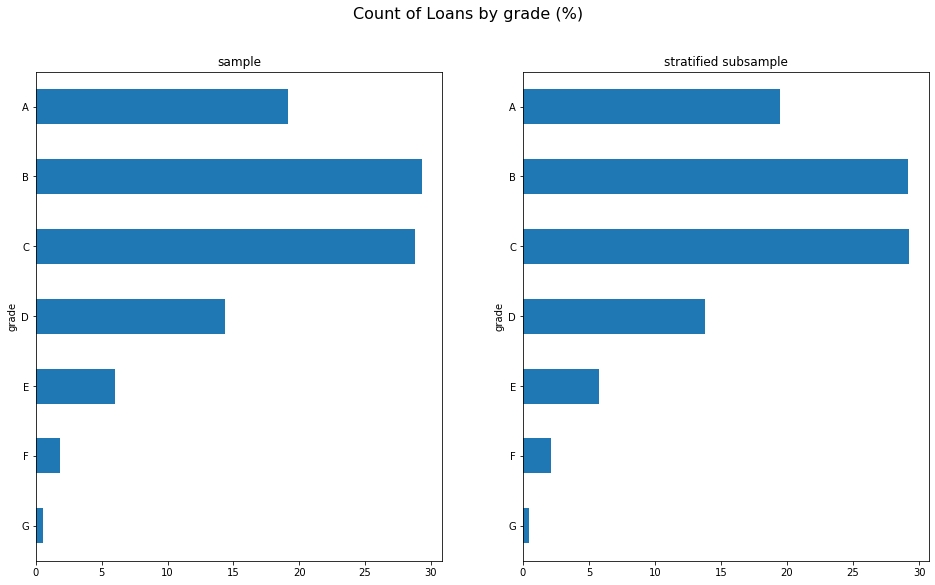

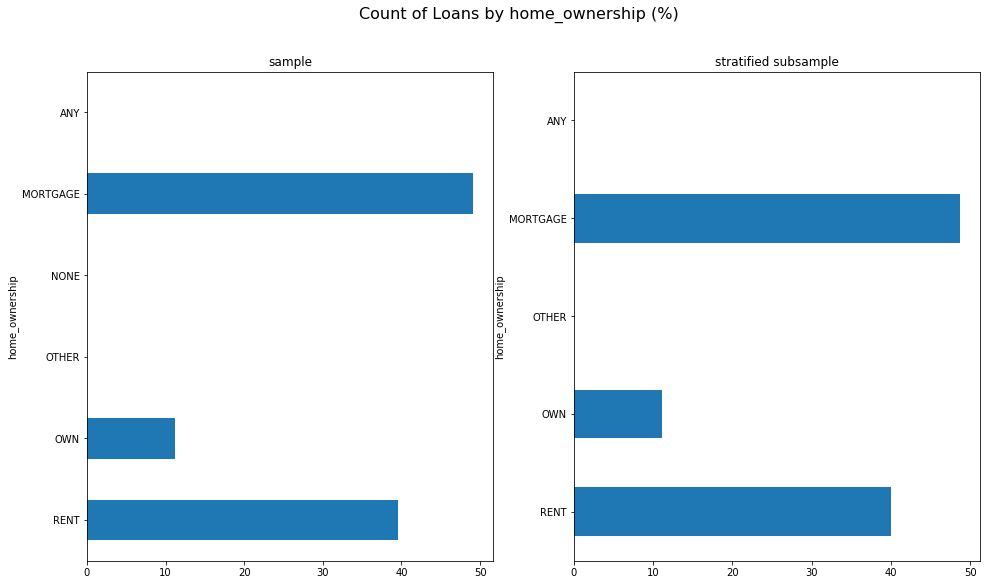

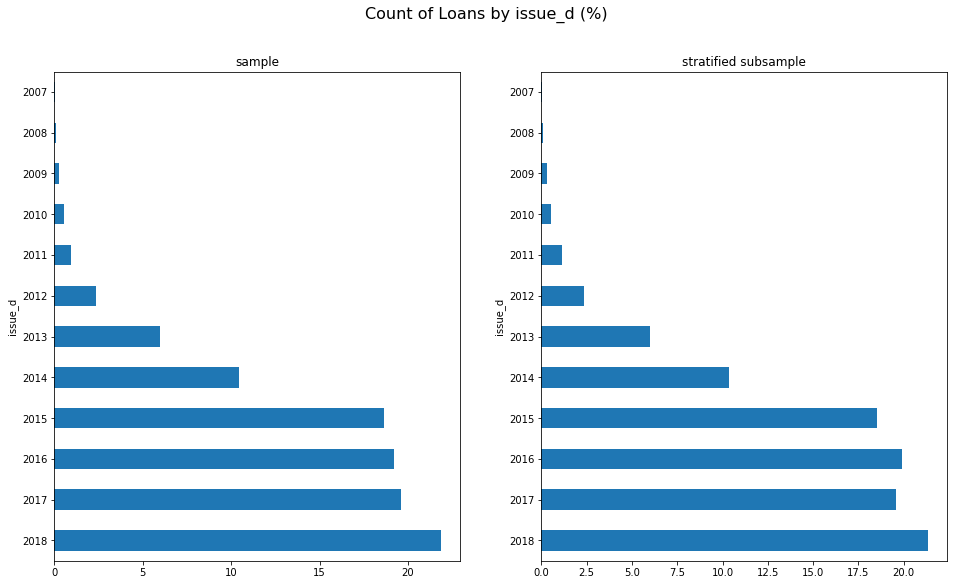

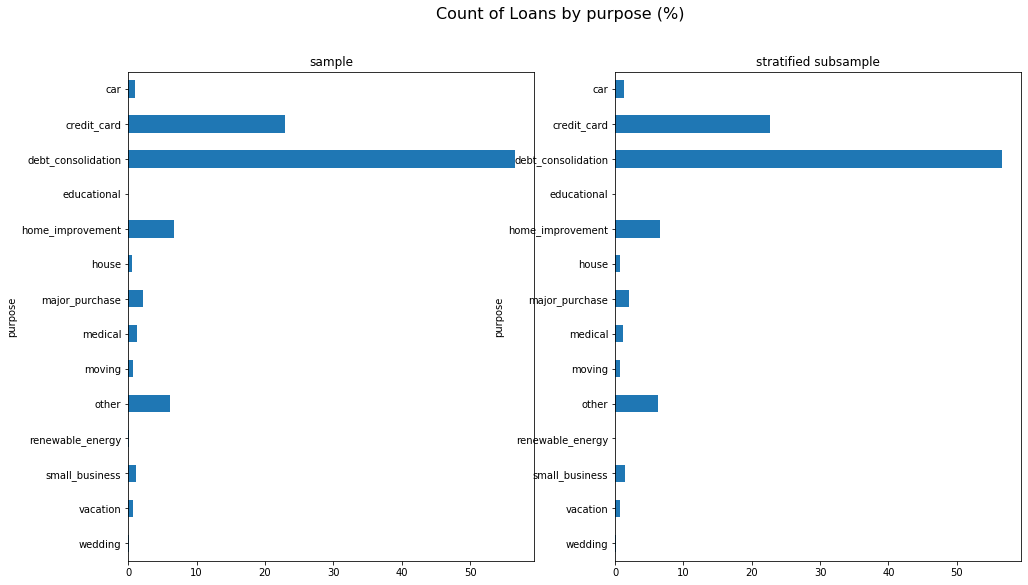

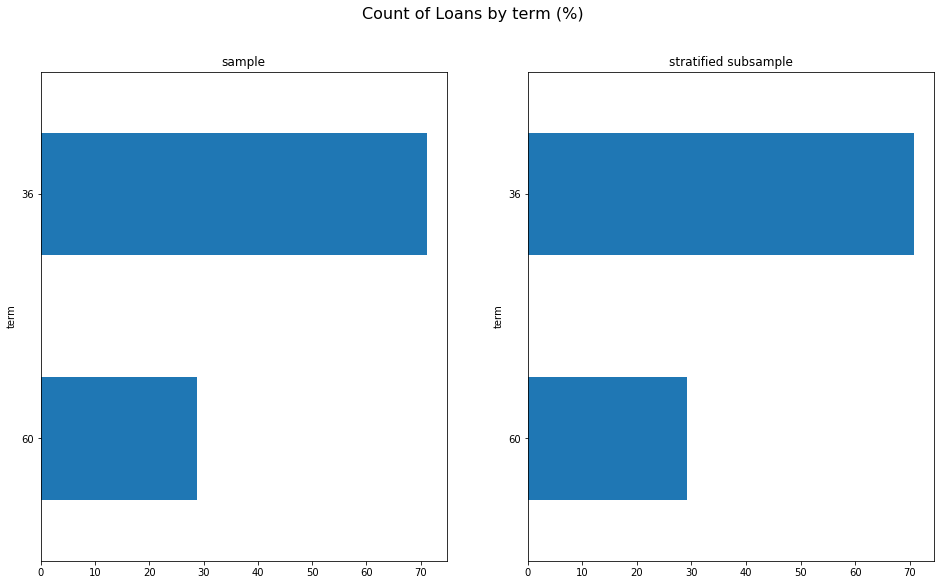

In [27]:
for col in np.intersect1d(data[columns].select_dtypes(include=['int64', 'float64']).columns, X.columns):
    fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(16, 9))
    fig.suptitle('Average ' + col + ' by Grade', fontsize=16)
    
    df = 100 * data.groupby(['grade'])[col].mean()
    df.sort_index(ascending=False).plot.barh(title='sample', rot=0, ax=axes[0])
    
    df = 100 * X_selected.groupby(['grade'])[col].mean()
    df.sort_index(ascending=False).plot.barh(title='stratified subsample', rot=0, ax=axes[1])
    
    plt.show()
    
for col in np.intersect1d(data[columns].select_dtypes(include=['object']).columns, X.columns):
    fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(16, 9))
    fig.suptitle('Count of Loans by ' + col + ' (%)', fontsize=16)
    
    df = 100 * data.groupby([col])['loan_amnt'].count() / data['loan_amnt'].count()
    df.sort_index(ascending=False).plot.barh(title='sample', rot=0, ax=axes[0])
    
    df = 100 * X_selected.groupby([col])['loan_amnt'].count() / X_selected['loan_amnt'].count()
    df.sort_index(ascending=False).plot.barh(title='stratified subsample', rot=0, ax=axes[1])
    
    plt.show()

So, it is safe to conclude that the stratified subsample is a good representation of the data set. Let's use this subsample for futher training and testing. 

In [28]:
data = X_selected.copy()
data[target] = y_selected

## Modeling

### Encoding Categorical Features

In [29]:
from sklearn.preprocessing import LabelEncoder

# for each column with type 'object'
for col in data.select_dtypes(include=['object']).columns:
    # Fill missing values in column with empty string
    data[col].fillna('', inplace=True)

    # Encode categorical feature
    encoder = LabelEncoder()
    data[col] = encoder.fit_transform(data[col])

### Feature Reduction

In [30]:
columns = [
    'id','member_id','url','funded_amnt','funded_amnt_inv','total_acc','out_prncp','out_prncp_inv','pymnt_plan',
    'open_acc','total_pymnt_inv','total_rec_prncp','total_rec_int','total_rec_late_fee','recoveries',
    'collection_recovery_fee', 'last_pymnt_d', 'last_pymnt_amnt', 'last_credit_pull_d', 'last_fico_range_high', 
    'last_fico_range_low', 'collections_12_mths_ex_med', 'acc_now_delinq', 'acc_open_past_24mths', 'bc_open_to_buy', 
    'bc_util', 'chargeoff_within_12_mths', 'delinq_amnt', 'mths_since_recent_bc', 'percent_bc_gt_75', 
    'pub_rec_bankruptcies', 'tax_liens', 'total_bal_ex_mort', 'total_bc_limit', 'hardship_flag', 'debt_settlement_flag', 
    'total_pymnt', 'next_pymnt_d', 'tot_coll_amt', 'hardship_type', 'hardship_reason', 'hardship_status', 'deferral_term', 
    'hardship_amount', 'hardship_start_date', 'hardship_end_date', 'payment_plan_start_date', 'hardship_length', 
    'hardship_dpd', 'hardship_loan_status', 'orig_projected_additional_accrued_interest', 'hardship_payoff_balance_amount', 
    'hardship_last_payment_amount', 'debt_settlement_flag_date', 'settlement_status', 'settlement_date', 'settlement_amount', 
    'settlement_percentage', 'settlement_term','issue_d','mo_sin_old_rev_tl_op','mo_sin_rec_rev_tl_op','policy_code', 'num_tl_30dpd',
]
data.drop(columns=np.intersect1d(columns, data.columns), inplace=True)

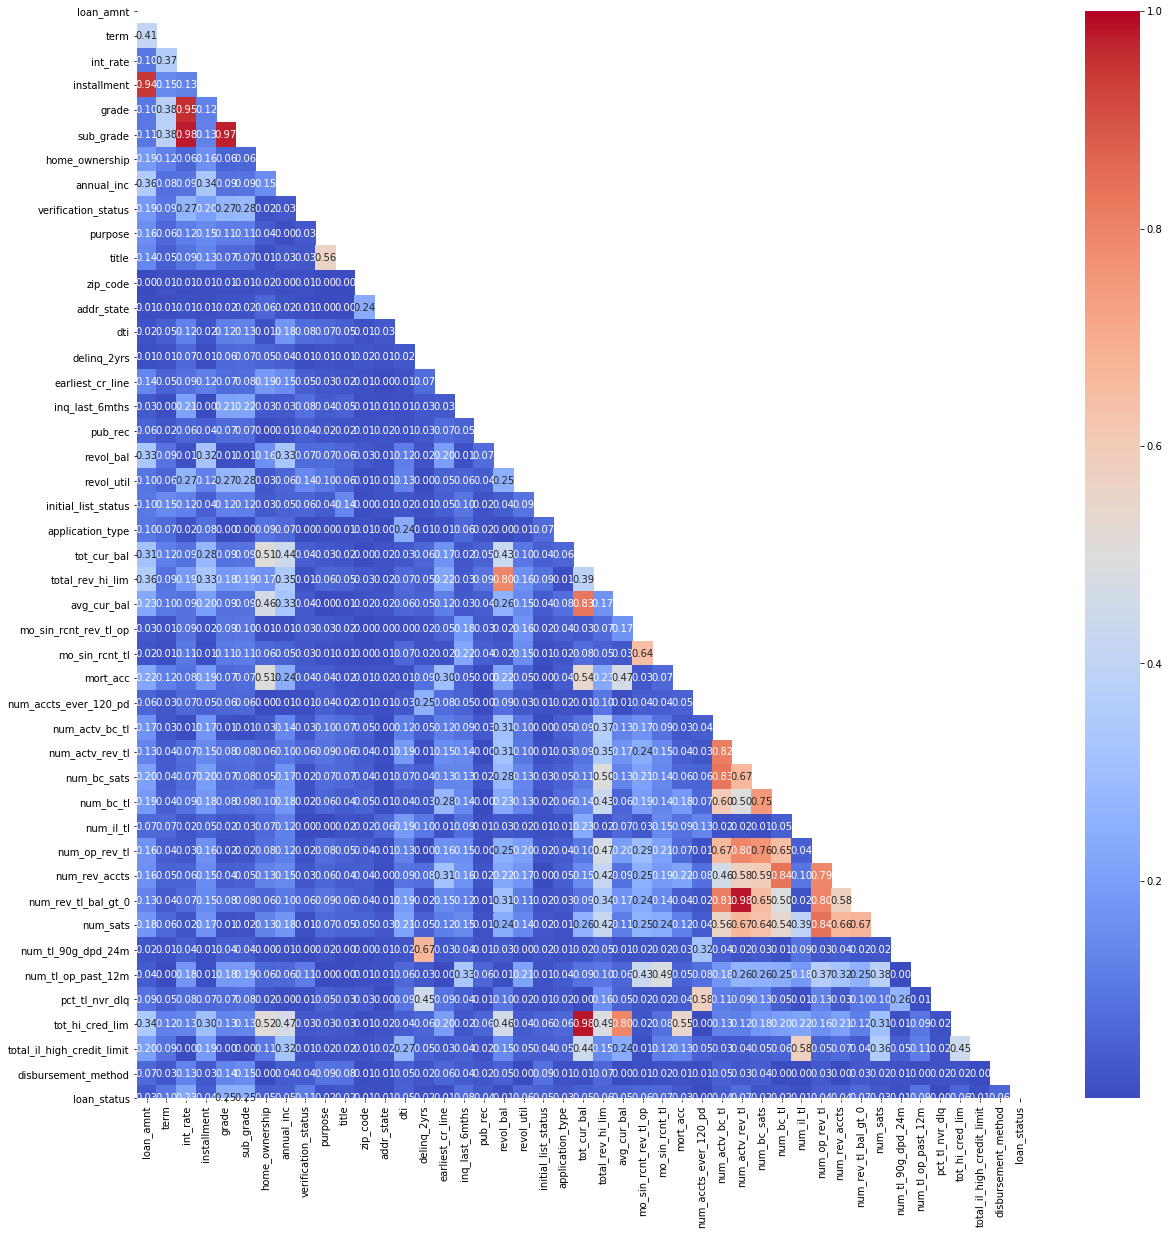

In [31]:
import seaborn as sns
plt.rcParams["figure.figsize"] = (20, 20)

corr = data.corr().abs()

# Generate a mask to ignore upper triangle
mask = np.zeros_like(corr, dtype=np.bool)
mask[np.triu_indices_from(mask)] = True

# Plot heatmap
sns.heatmap(corr, xticklabels=corr.columns, yticklabels=corr.columns, annot=True, mask=mask, cmap='coolwarm', fmt='.2f')

Now, let's drop one feature for every pair of highly correlated features.  

In [32]:
columns = [
    'int_rate','sub_grade','installment','title','all_util','avg_cur_bal','tot_cur_bal','total_bal_il','open_il_12m',
    'open_il_24m','open_rv_12m','open_rv_24m','num_accts_ever_120_pd','num_actv_bc_tl','num_actv_rev_tl','num_bc_sats',
    'num_bc_tl','num_il_tl','num_op_rev_tl','num_rev_accts','num_rev_tl_bal_gt_0','num_sats','num_tl_90g_dpd_24m',
    'num_tl_op_past_12m','revol_bal','zip_code','addr_state','application_type','mo_sin_rcnt_rev_tl_op','mo_sin_rcnt_tl',
    'total_rev_hi_lim','total_il_high_credit_limit','purpose','initial_list_status','disbursement_method'
]
data.drop(columns=np.intersect1d(columns, data.columns), inplace=True)

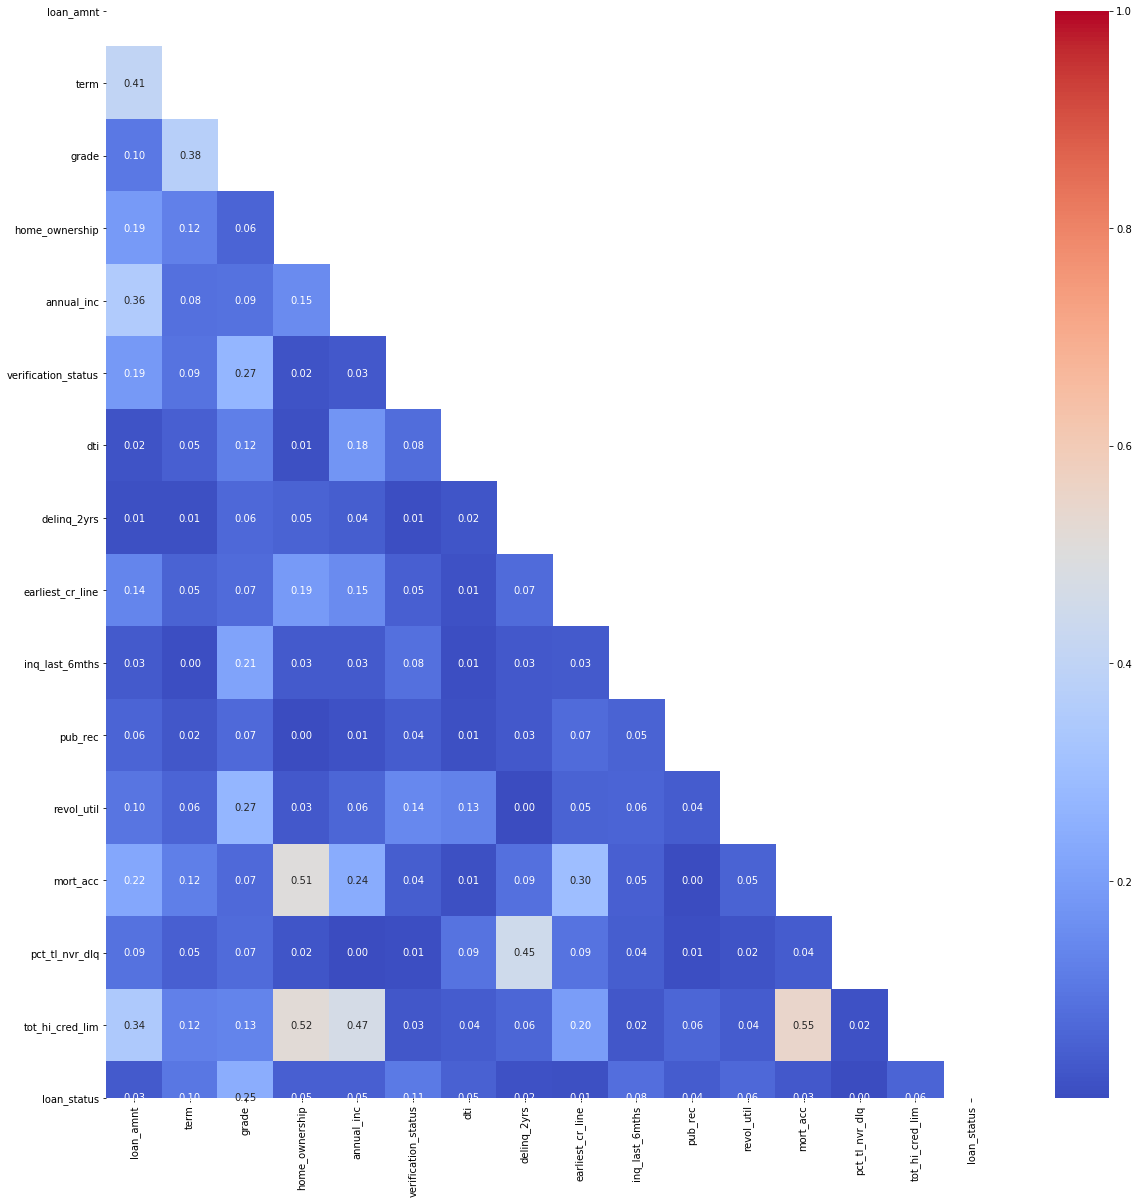

In [33]:
import seaborn as sns
plt.rcParams["figure.figsize"] = (20, 20)

corr = data.corr().abs()

# Generate a mask to ignore upper triangle
mask = np.zeros_like(corr, dtype=np.bool)
mask[np.triu_indices_from(mask)] = True

# Plot heatmap
sns.heatmap(corr, xticklabels=corr.columns, yticklabels=corr.columns, annot=True, mask=mask, cmap='coolwarm', fmt='.2f')

### Finally

After all pre-processing steps, our final dataset looks like this.

In [34]:
data.sample(3)

,loan_amnt,term,grade,home_ownership,annual_inc,verification_status,dti,delinq_2yrs,earliest_cr_line,inq_last_6mths,pub_rec,revol_util,mort_acc,pct_tl_nvr_dlq,tot_hi_cred_lim,loan_status
1160010,14000,0,1,1,55000.0,0,15.73,0.0,33,0.0,1.0,83.6,1.0,100.0,162885.0,1
1810300,15000,0,1,1,47779.0,2,23.21,0.0,27,0.0,0.0,98.8,2.0,96.0,171694.0,1
1975009,7200,0,0,1,90000.0,2,17.58,0.0,36,2.0,0.0,1.2,4.0,100.0,373473.0,1


In [35]:
data.shape

(10000, 16)

## Modeling

Let's split the stratified sample again into train and test samples. 

In [36]:
from sklearn.model_selection import train_test_split

target = 'loan_status'
X = data.drop(target, axis='columns', inplace=False)
y = data[target]

# default split is 25%
X_train, X_test, y_train, y_test = train_test_split(X, y, stratify=y, random_state=123)

### Feature Selection

Some features are more important than others. Features with low importance add noise, and must be removed. 

A trained RandomForestClassifier can be used to identify importance of features. 


In [37]:
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import StandardScaler
from sklearn.ensemble import RandomForestClassifier
from sklearn.pipeline import Pipeline

X = data.drop(target, axis='columns', inplace=False)
y = data[target]

# create a Random Forest Classifier pipeline
rf_pipeline = Pipeline([
    ('imputer', SimpleImputer()), # fill missing values with mean of column
    ('scaler', StandardScaler()), # normalize values
    ('classifier', RandomForestClassifier(n_estimators=100, random_state=123, n_jobs=-1))
])
rf_pipeline.fit(X, y)

Pipeline(memory=None,
         steps=[('imputer',
                 SimpleImputer(add_indicator=False, copy=True, fill_value=None,
                               missing_values=nan, strategy='mean',
                               verbose=0)),
                ('scaler',
                 StandardScaler(copy=True, with_mean=True, with_std=True)),
                ('classifier',
                 RandomForestClassifier(bootstrap=True, class_weight=None,
                                        criterion='gini', max_depth=None,
                                        max_features='auto',
                                        max_leaf_nodes=None,
                                        min_impurity_decrease=0.0,
                                        min_impurity_split=None,
                                        min_samples_leaf=1, min_samples_split=2,
                                        min_weight_fraction_leaf=0.0,
                                        n_estimators=100, n_jobs=-1,
 

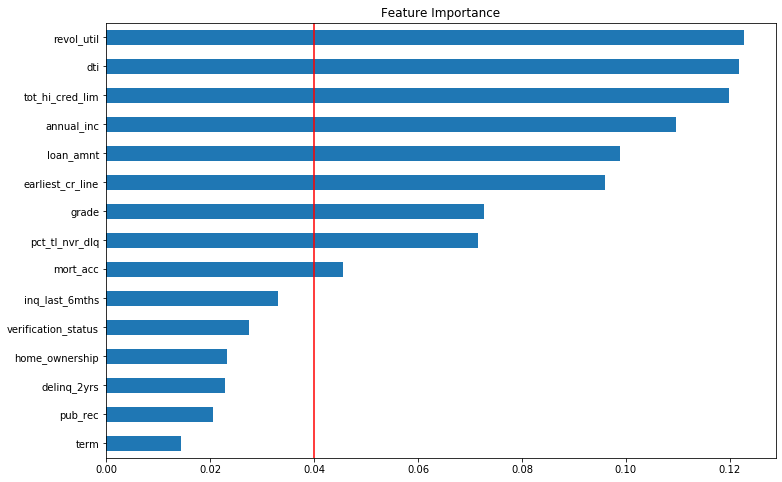

In [38]:
# Plot the name and gini importance of each feature
plt.rcParams["figure.figsize"] = (12, 8)
imp_features=pd.Series(rf_pipeline.named_steps['classifier'].feature_importances_, index=X.columns)
imp_features.sort_values().plot(title='Feature Importance', kind='barh')

# draw red verticle line at threshold
plt.axvline(x=0.04, c='r')

In [39]:
important_features = list(imp_features.sort_values(ascending=False)[imp_features > 0.04].keys())
X[important_features].head()

,revol_util,dti,tot_hi_cred_lim,annual_inc,loan_amnt,earliest_cr_line,grade,pct_tl_nvr_dlq,mort_acc
1643453,52.7,10.03,47453.0,75000.0,10000,47,2,100.0,0.0
1491854,78.0,19.35,42310.0,80000.0,24050,33,2,86.0,0.0
113184,49.5,28.11,111543.0,78000.0,11000,28,0,100.0,0.0
1580844,48.3,15.46,20300.0,50000.0,15000,52,3,100.0,0.0
527944,63.2,26.52,79095.0,72000.0,14250,45,4,96.3,1.0


Let us verify that the selected features have low correlation. 

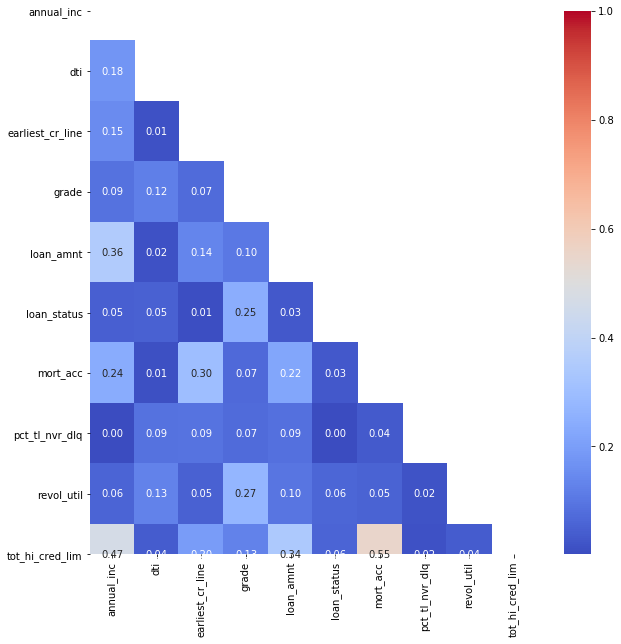

In [40]:
import seaborn as sns
plt.rcParams["figure.figsize"] = (10, 10)

corr = data[np.union1d(important_features, target)].corr().abs()

# Generate a mask to ignore upper triangle
mask = np.zeros_like(corr, dtype=np.bool)
mask[np.triu_indices_from(mask)] = True

# Plot heatmap
sns.heatmap(corr, xticklabels=corr.columns, yticklabels=corr.columns, annot=True, mask=mask, cmap='coolwarm', fmt='.2f')

Let us now build a SelectFromModel step to ignore features with low importance. 

In [41]:
from sklearn.feature_selection import SelectFromModel
#select_important_features = SelectFromModel(rf_pipeline.named_steps['classifier'], max_features=10, threshold=-np.inf)
select_important_features = SelectFromModel(rf_pipeline.named_steps['classifier'], threshold=0.04)

### Logistic Regression

Let us build, evaluate and tune a LogisticRegression model. 

In [42]:
from sklearn.feature_selection import SelectFromModel
from sklearn.model_selection import GridSearchCV
from sklearn.linear_model import LogisticRegression

# for tuning hyper parameters
param_grid = [
    {
        'solver': ['newton-cg', 'lbfgs', 'sag'],
        'penalty': ['none', 'l2']
    },
    {
        'solver': ['liblinear', 'saga'],
        'penalty': ['l1']
    }
]

lr_pipeline = Pipeline([
    ('imputer', SimpleImputer()), # fill missing values with mean of column
    ('selector', select_important_features), # select only the important features
    ('scaler', StandardScaler()), 
    ('classifier',GridSearchCV(LogisticRegression(random_state=123),param_grid=param_grid,cv=3,refit=True,n_jobs=-1))
])
lr_pipeline.fit(X_train, y_train)

Pipeline(memory=None,
         steps=[('imputer',
                 SimpleImputer(add_indicator=False, copy=True, fill_value=None,
                               missing_values=nan, strategy='mean',
                               verbose=0)),
                ('selector',
                 SelectFromModel(estimator=RandomForestClassifier(bootstrap=True,
                                                                  class_weight=None,
                                                                  criterion='gini',
                                                                  max_depth=None,
                                                                  max_features='auto',
                                                                  max_leaf_nodes=None,
                                                                  min_impurity_decrease=0.0,
                                                                  min_impurity...
                                               

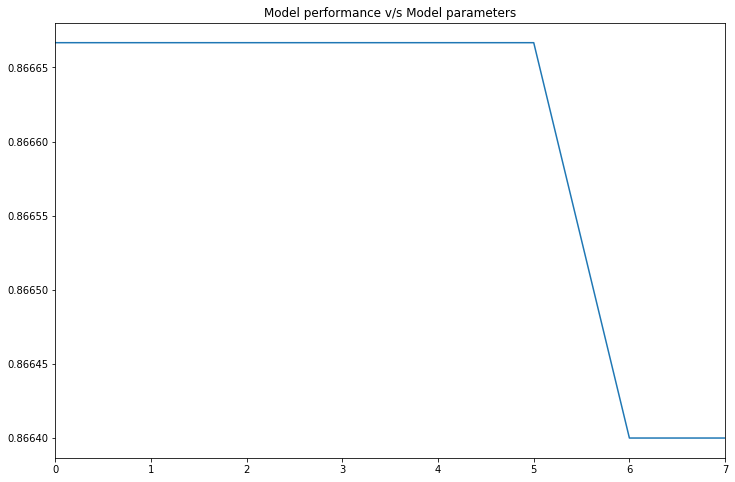

In [43]:
# plot model performance for each parameter set
plt.rcParams["figure.figsize"] = (12, 8)

series=pd.Series(lr_pipeline.named_steps['classifier'].cv_results_['mean_test_score'])
series.plot(title='Model performance v/s Model parameters')

In [44]:
lr_pipeline.named_steps['classifier'].best_score_

0.8666666666666667

In [45]:
lr_pipeline.named_steps['classifier'].best_params_

{'penalty': 'none', 'solver': 'newton-cg'}

In [49]:
# Calculate area under the ROC curve score

from sklearn.model_selection import cross_val_score
np.mean(cross_val_score(lr_pipeline, X_test, y_test, cv=3))

0.8683995111603026

Text(0, 0.5, 'Actual')

<Figure size 360x360 with 0 Axes>

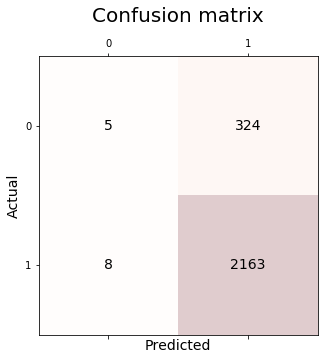

In [48]:
# Confusion Matrix
from sklearn.metrics import confusion_matrix

predictions = lr_pipeline.predict(X_test)
conf_mat = confusion_matrix(y_test, predictions)

plt.rcParams["figure.figsize"] = (5, 5)
plt.figure(figsize=(5, 5))
plt.matshow(conf_mat, cmap=plt.cm.Reds, alpha=0.2)

for i in range(2):
    for j in range(2):
        plt.text(x=j, y=i, s=conf_mat[i, j], ha="center", va="center", fontdict={"fontsize": 14})

plt.title("Confusion matrix", y=1.1, fontdict={"fontsize": 20})
plt.xlabel("Predicted", fontdict={"fontsize": 14})
plt.ylabel("Actual", fontdict={"fontsize": 14})

### Gradient Boosting Classifier

Now, let us build, evaluate and tune a GradientBoostingClassifier. 

In [57]:
from sklearn.ensemble import GradientBoostingClassifier

# for tuning hyper parameters 
param_grid = {
    'n_estimators': [100, 500],
    'max_features': [None, 'sqrt'],
    'learning_rate': [0.1, 0.5],
    'max_leaf_nodes': [2, 8],
    'min_samples_split': [0.1, 0.3]
}

gb_pipeline = Pipeline([
    ('imputer', SimpleImputer()), # fill missing values with mean of column
    ('selector', select_important_features), # select only the important features
    ('scaler', StandardScaler()),
    ('classifier', GridSearchCV(GradientBoostingClassifier(), param_grid=param_grid, cv=3, refit=True, n_jobs=-1))
])
gb_pipeline.fit(X_train, y_train)

Pipeline(memory=None,
         steps=[('imputer',
                 SimpleImputer(add_indicator=False, copy=True, fill_value=None,
                               missing_values=nan, strategy='mean',
                               verbose=0)),
                ('selector',
                 SelectFromModel(estimator=RandomForestClassifier(bootstrap=True,
                                                                  class_weight=None,
                                                                  criterion='gini',
                                                                  max_depth=None,
                                                                  max_features='auto',
                                                                  max_leaf_nodes=None,
                                                                  min_impurity_decrease=0.0,
                                                                  min_impurity...
                                               

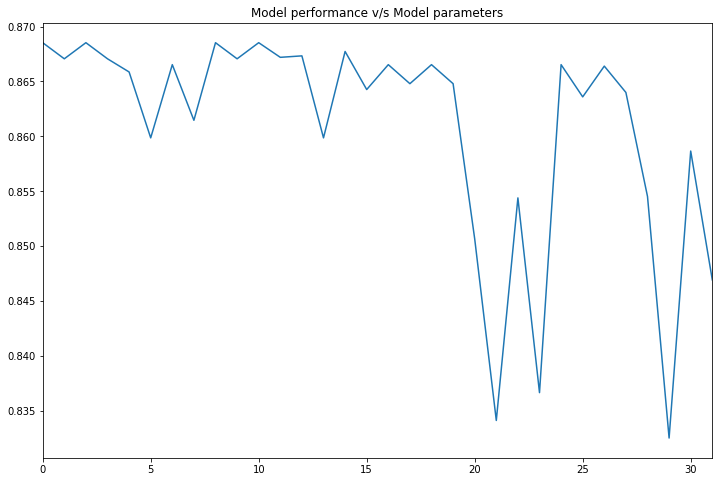

In [58]:
plt.rcParams["figure.figsize"] = (12, 8)

series=pd.Series(gb_pipeline.named_steps['classifier'].cv_results_['mean_test_score'])
series.plot(title='Model performance v/s Model parameters')

In [59]:
gb_pipeline.named_steps['classifier'].best_score_

0.8685333333333334

In [60]:
gb_pipeline.named_steps['classifier'].best_params_

{'learning_rate': 0.1,
 'max_features': None,
 'max_leaf_nodes': 2,
 'min_samples_split': 0.1,
 'n_estimators': 100}

Text(0, 0.5, 'Actual')

<Figure size 360x360 with 0 Axes>

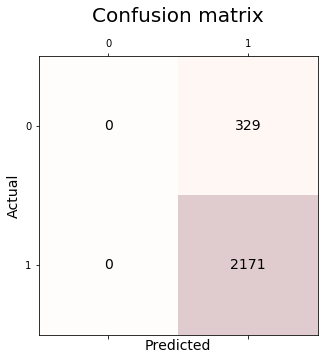

In [61]:
# Confusion Matrix
from sklearn.metrics import confusion_matrix

predictions = gb_pipeline.predict(X_test)
conf_mat = confusion_matrix(y_test, predictions)

plt.rcParams["figure.figsize"] = (5, 5)
plt.figure(figsize=(5, 5))
plt.matshow(conf_mat, cmap=plt.cm.Reds, alpha=0.2)

for i in range(2):
    for j in range(2):
        plt.text(x=j, y=i, s=conf_mat[i, j], ha="center", va="center", fontdict={"fontsize": 14})

plt.title("Confusion matrix", y=1.1, fontdict={"fontsize": 20})
plt.xlabel("Predicted", fontdict={"fontsize": 14})
plt.ylabel("Actual", fontdict={"fontsize": 14})

### Neural Networks

Now, let us try to build, evaluate and tune a Neural Network. 

In [62]:
from keras.models import Sequential
from keras.layers import Dense
from keras.layers import Dropout
from keras.wrappers.scikit_learn import KerasClassifier

# This function is a template for creating neural networks
def build_classifier(optimizer='adam', layers=2, add_dropout_layers=False, dropout_rate=0.1):
    # first step: create a Sequential object, as a sequence of layers. B/C NN is a sequence of layers.
    classifier = Sequential()
    
    for i in range(layers):
        # add the hidden layer
        classifier.add(Dense(units=5,kernel_initializer='glorot_uniform',activation = 'relu'))
        
        # add dropout layer
        if add_dropout_layers:
            classifier.add(Dropout(rate=dropout_rate))  #often start with 0.1, not solved go up
    
    # add the output layer
    classifier.add(Dense(units=1,kernel_initializer='glorot_uniform',activation = 'sigmoid'))
    
    # compiling the NN
    classifier.compile(optimizer=optimizer,loss='binary_crossentropy',metrics=['accuracy'])
    return classifier


# a neural network
classifier = KerasClassifier(build_fn=build_classifier, batch_size=10, nb_epoch=3)

# for tuning hyper parameters 
param_grid = {
    'batch_size':[10, 100], 
    'nb_epoch':[1, 10],
    'optimizer':['adam','rmsprop'],
    'layers': [0, 1, 2],
    'add_dropout_layers': [False, True]
}

nn_pipeline = Pipeline([
    ('imputer', SimpleImputer()),  # fill missing values with mean of column
    ('selector', select_important_features),  # select only the important features
    ('scaler', StandardScaler()),  # scale values to range [0,1]
    ('classifier', GridSearchCV(classifier, param_grid=param_grid, cv=3, scoring='accuracy', refit=True, n_jobs=-1))  
])
nn_pipeline.fit(X_train, y_train)

Using TensorFlow backend.


Epoch 1/1
7500/7500 [==============================] - 1s 84us/step - loss: 0.4822 - accuracy: 0.8109


Pipeline(memory=None,
         steps=[('imputer',
                 SimpleImputer(add_indicator=False, copy=True, fill_value=None,
                               missing_values=nan, strategy='mean',
                               verbose=0)),
                ('selector',
                 SelectFromModel(estimator=RandomForestClassifier(bootstrap=True,
                                                                  class_weight=None,
                                                                  criterion='gini',
                                                                  max_depth=None,
                                                                  max_features='auto',
                                                                  max_leaf_nodes=None,
                                                                  min_impurity_decrease=0.0,
                                                                  min_impurity...
                 GridSearchCV(cv=3, error_score

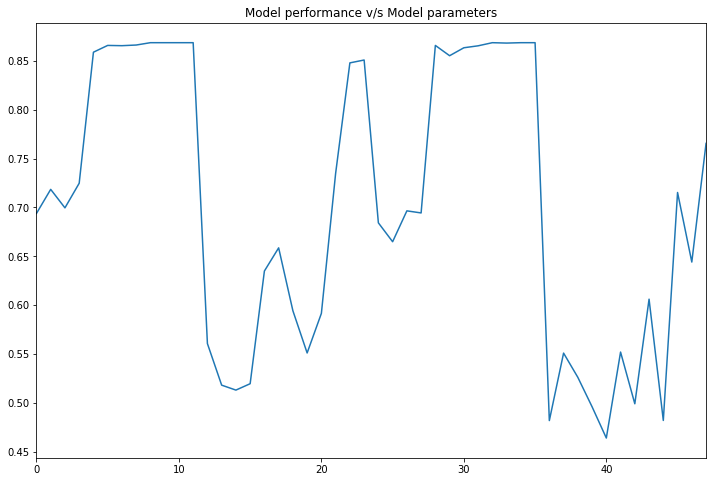

In [63]:
plt.rcParams["figure.figsize"] = (12, 8)

series=pd.Series(nn_pipeline.named_steps['classifier'].cv_results_['mean_test_score'])
series.plot(title='Model performance v/s Model parameters')

In [64]:
nn_pipeline.named_steps['classifier'].best_score_

0.8686666666666667

In [65]:
nn_pipeline.named_steps['classifier'].best_params_

{'add_dropout_layers': False,
 'batch_size': 10,
 'layers': 2,
 'nb_epoch': 1,
 'optimizer': 'adam'}

Text(0, 0.5, 'Actual')

<Figure size 360x360 with 0 Axes>

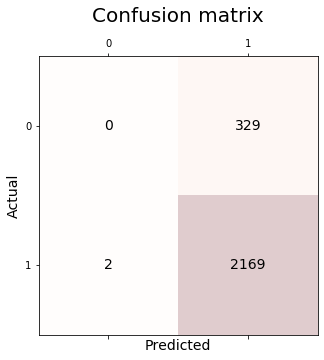

In [66]:
# Confusion Matrix
predictions = nn_pipeline.predict(X_test)
conf_mat = confusion_matrix(y_test, predictions)

plt.rcParams["figure.figsize"] = (5, 5)
plt.figure(figsize=(5, 5))
plt.matshow(conf_mat, cmap=plt.cm.Reds, alpha=0.2)

for i in range(2):
    for j in range(2):
        plt.text(x=j, y=i, s=conf_mat[i, j], ha="center", va="center", fontdict={"fontsize": 14})

plt.title("Confusion matrix", y=1.1, fontdict={"fontsize": 20})
plt.xlabel("Predicted", fontdict={"fontsize": 14})
plt.ylabel("Actual", fontdict={"fontsize": 14})

## Model Evaluation

Let us now compare all the models we have built. 

In [69]:
import warnings
warnings.filterwarnings('ignore')
warnings.filterwarnings(action='ignore',category=DeprecationWarning)
warnings.filterwarnings(action='ignore',category=FutureWarning)

from sklearn.model_selection import cross_val_score


model_evaluation = [
    {
        'Model': 'LogisticRegression', 
        'AUC-Train': np.mean(cross_val_score(lr_pipeline, X_train, y_train, scoring="roc_auc", cv=3)),
        'AUC-Test': np.mean(cross_val_score(lr_pipeline, X_test, y_test, scoring="roc_auc", cv=3))
    },
    {
        'Model': 'GradientBoostingClassifier', 
        'AUC-Train': np.mean(cross_val_score(gb_pipeline, X_train, y_train, scoring="roc_auc", cv=3)),
        'AUC-Test': np.mean(cross_val_score(gb_pipeline, X_test, y_test, scoring="roc_auc", cv=3))
    },
    {
        'Model': 'KerasClassifier', 
        'AUC-Train': np.mean(cross_val_score(nn_pipeline, X_train, y_train, scoring="roc_auc", cv=3)),
        'AUC-Test': np.mean(cross_val_score(nn_pipeline, X_test, y_test, scoring="roc_auc", cv=3))
    },
]

df=pd.DataFrame(model_evaluation)
df

Epoch 1/1
5000/5000 [==============================] - 0s 98us/step - loss: 0.5305 - accuracy: 0.8094
Epoch 1/1
5000/5000 [==============================] - 0s 95us/step - loss: 0.4795 - accuracy: 0.8562
Epoch 1/1
5000/5000 [==============================] - 1s 107us/step - loss: 0.5817 - accuracy: 0.7626
Epoch 1/1
1666/1666 [==============================] - 0s 141us/step - loss: 0.7098 - accuracy: 0.6206
Epoch 1/1
1667/1667 [==============================] - 0s 122us/step - loss: 0.6189 - accuracy: 0.7516
Epoch 1/1
1667/1667 [==============================] - 0s 145us/step - loss: 0.5693 - accuracy: 0.7852


,Model,AUC-Train,AUC-Test
0,LogisticRegression,0.708270,0.687285
1,GradientBoostingClassifier,0.704424,0.676376
2,KerasClassifier,0.565342,0.550470
